In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#import plotly.graph_objs as go
%matplotlib inline

In [2]:
from pandas_datareader import data as pdr

In [3]:
days_to_extract = 1000
days_to_forecast = 20

In [4]:
date_end = dt.date.today()
date_start = date_end - dt.timedelta(days_to_extract)

In [5]:
date_end, date_start

(datetime.date(2022, 4, 16), datetime.date(2019, 7, 21))

In [6]:
df = pdr.DataReader("VUSA.L", 'yahoo', date_start, date_end).reset_index()

df = df.loc[df['Date'].notnull()]

In [7]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-07-22,45.435001,45.182499,45.205002,45.271252,216161,45.271252
1,2019-07-23,45.750000,45.555000,45.555000,45.632500,154418,45.632500
2,2019-07-24,45.805000,45.474998,45.799999,45.632500,290342,45.632500
3,2019-07-25,45.994999,45.622501,45.980000,45.740002,250089,45.740002
4,2019-07-26,46.209999,45.942501,45.980000,46.291248,126366,46.291248


In [8]:
df.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object

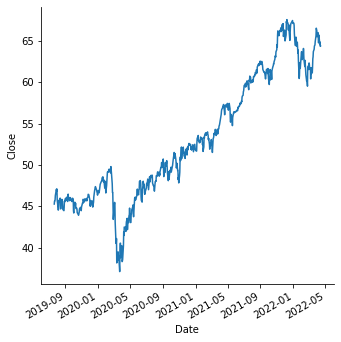

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df).fig.autofmt_xdate()

# preprocessing

In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
le = preprocessing.LabelEncoder()

In [11]:
df['Date encoded'] = le.fit_transform(df['Date'])

In [12]:
days_cutoff = len(df) - days_to_forecast

In [13]:
scaled_Close = scaler.fit_transform(df[['Close']])

In [14]:
scaled_Close = np.squeeze(scaled_Close)

In [15]:
df.values[days_cutoff:, 7]

array([674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686,
       687, 688, 689, 690, 691, 692, 693], dtype=object)

In [16]:
x_train, y_train = df.values[:days_cutoff, 7], scaled_Close[:days_cutoff]
x_test, y_test = df.values[days_cutoff:, 7], scaled_Close[days_cutoff:]

x_train, y_train = df.values[:600, 0], scaled_Close[:600]
x_test, y_test = df.values[600:, 0], scaled_Close[600:]

In [17]:
x_train.shape, x_test.shape

((674,), (20,))

# split train data

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2)


## statsmodels

In [19]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Date encoded
0,2019-07-22,45.435001,45.182499,45.205002,45.271252,216161,45.271252,0
1,2019-07-23,45.750000,45.555000,45.555000,45.632500,154418,45.632500,1
2,2019-07-24,45.805000,45.474998,45.799999,45.632500,290342,45.632500,2
3,2019-07-25,45.994999,45.622501,45.980000,45.740002,250089,45.740002,3
4,2019-07-26,46.209999,45.942501,45.980000,46.291248,126366,46.291248,4


In [20]:
data = df.set_index('Date')

<AxesSubplot:xlabel='Date'>

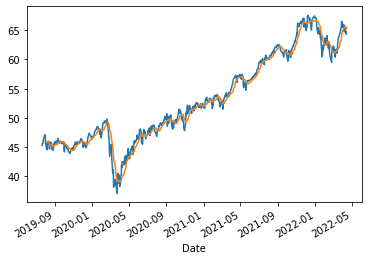

In [23]:
data.Close.plot()
data.Close.rolling(12).mean().plot(label= '12 month rolling mean')
#data.Close.rolling(12).std().plot(label='12 month rolling std')

<AxesSubplot:xlabel='Date'>

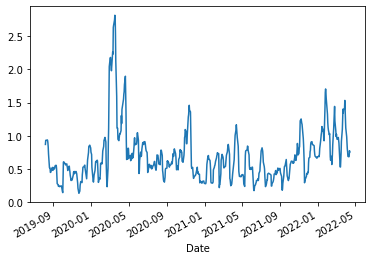

In [22]:
data.Close.rolling(12).std().plot(label='12 month rolling std')

In [24]:
#import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import plotly.graph_objects as go

#### additive seasonality

Y[t] = T[t] + S[t] + e[t]

Y[t]: Our time-series function

T[t]: Trend (general tendency to move up or down)

S[t]: Seasonality (cyclic pattern occurring at regular intervals)

e[t]: Residual (random noise in the data that isn’t accounted for in the trend or seasonality

#### multiplicative seasonality

Y[t] = T[t] *S[t] *e[t]

In [29]:
decomposition = seasonal_decompose(data.Close, model='multiplicative', period=100)

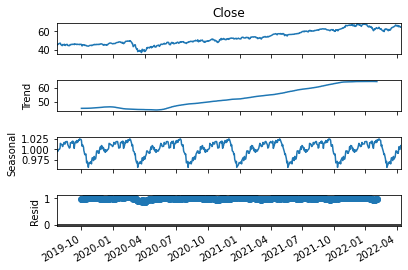

In [30]:
decomposition.plot().autofmt_xdate()

<AxesSubplot:xlabel='Date'>

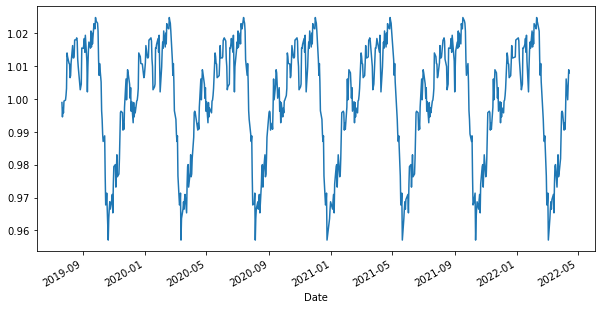

In [27]:
plt.figure(figsize=(10, 5))
decomposition.seasonal.plot()
#plt.plot(decomposition.seasonal)

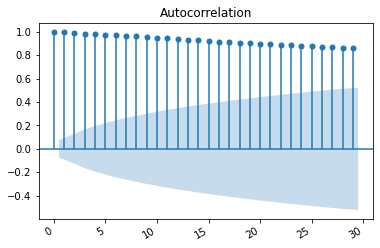

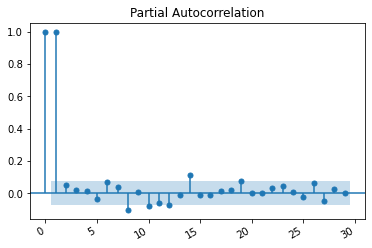

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.Close).autofmt_xdate()
plot_pacf(data.Close).autofmt_xdate()